# Diagnostico Automatico de Afecciones Dermatologicas usando Transfer Learning

***Generative AI with Large Language Models***

***Elaborado por Juan Francisco Teran, 08/12/2024***

## Human Against Machine with 10000 training images (HAM10000)

***El dataset se compone de 10,015 imagenes previamente etiquetadas.***

## Importacion de bibliotecas y conjunto de datos

***El siguiente codigo es basado en las siguientes librerias de Python:***

In [1]:
import pandas as pd
import numpy as np

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from tqdm import tqdm

from tensorflow.keras.applications import Xception
from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input as base_preprocess

#from tensorflow.keras.layers import Flatten, BatchNormalization

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


***El codigo utilizado en este Jupyter Notebook es adaptado de la documentacion oficial de las librerias Python, antes mencionadas.***

## Creando y cargando el Dataset

In [2]:
path = "Dataset"
path_test = "Test"
classes = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]

In [ ]:
os.mkdir(path)
os.mkdir(path_test)
for subdir in classes:
    os.mkdir(os.path.join(path, subdir))
    os.mkdir(os.path.join(path_test, subdir))

In [3]:
os.listdir(path)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [4]:
df = pd.read_csv("dermatology/HAM10000_metadata", index_col=1)

In [5]:
df

,lesion_id,dx,dx_type,age,sex,localization,dataset
image_id,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,vidir_modern
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,vidir_modern
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,vidir_modern
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,vidir_modern
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...
ISIC_0033084,HAM_0002867,akiec,histo,40.0,male,abdomen,vidir_modern
ISIC_0033550,HAM_0002867,akiec,histo,40.0,male,abdomen,vidir_modern
ISIC_0033536,HAM_0002867,akiec,histo,40.0,male,abdomen,vidir_modern


In [6]:
df_test = pd.read_csv("dermatology/ISIC2018_Task3_Test_GroundTruth.csv", index_col=1)

In [7]:
df_test

,lesion_id,dx,dx_type,age,sex,localization,dataset
image_id,,,,,,,
ISIC_0034524,HAMTEST_0000000,nv,follow_up,40.0,female,back,vidir_molemax
ISIC_0034525,HAMTEST_0000001,nv,histo,70.0,male,abdomen,rosendahl
ISIC_0034526,HAMTEST_0000002,bkl,histo,70.0,male,back,rosendahl
ISIC_0034527,HAMTEST_0000003,nv,histo,35.0,male,trunk,vienna_dias
ISIC_0034528,HAMTEST_0000004,nv,follow_up,75.0,female,trunk,vidir_molemax
...,...,...,...,...,...,...,...
ISIC_0036060,HAMTEST_0001219,bkl,consensus,NaN,unknown,unknown,external
ISIC_0036061,HAMTEST_0001220,nv,consensus,NaN,unknown,unknown,external
ISIC_0036062,HAMTEST_0001107,akiec,histo,70.0,female,face,vidir_modern


In [ ]:
image_subdirs = ["dermatology\HAM10000_images_part_1", "dermatology\HAM10000_images_part_2"]

for image_subdir in image_subdirs:
    images = os.listdir(image_subdir)
    
    for image in tqdm(images, desc=f'Processing {image_subdir}'):
        image_id = image[:-4]
        if image_id in df.index: 
            category = df.loc[image_id, "dx"]
            initial_path = os.path.join(image_subdir, image)
            final_path = os.path.join(path, category, image)
            shutil.copyfile(initial_path, final_path)

"Done"

In [60]:
image_subdir_test = "dermatology\ISIC2018_Task3_Test_Images\ISIC2018_Task3_Test_Images"

images = os.listdir(image_subdir_test)
    
for image in tqdm(images, desc=f'Processing {image_subdir_test}'):
    image_id = image[:-4]
    if image_id in df_test.index: 
        category = df_test.loc[image_id, "dx"]
        initial_path = os.path.join(image_subdir_test, image)
        final_path = os.path.join(path_test, category, image)
        shutil.copyfile(initial_path, final_path)

"Done"

Processing dermatology\ISIC2018_Task3_Test_Images\ISIC2018_Task3_Test_Images: 100%|██████████| 1512/1512 [00:24<00:00, 62.12it/s]


'Done'

## Entendimiento

### Descripcion del Dataset

#### Dimensionalidad

In [8]:
dimension = df.shape
print("Rows: ", dimension[0], "\n" "Columns: ", dimension[1])
print("Dimensionality:", dimension[1]) 

Rows:  10015 
Columns:  7
Dimensionality: 7


#### Atributos

##### Resumen de los tipos de atributos

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10015 entries, ISIC_0027419 to ISIC_0032258
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   dx            10015 non-null  object 
 2   dx_type       10015 non-null  object 
 3   age           9958 non-null   float64
 4   sex           10015 non-null  object 
 5   localization  10015 non-null  object 
 6   dataset       10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 625.9+ KB


##### Resumen de las estadisticas descriptivas de cada atributo

In [10]:
df.describe(include='all')

,lesion_id,dx,dx_type,age,sex,localization,dataset
count,10015,10015,10015,9958.000000,10015,10015,10015
unique,7470,7,4,NaN,3,15,4
top,HAM_0000835,nv,histo,NaN,male,back,vidir_molemax
freq,6,6705,5340,NaN,5406,2192,3954
mean,NaN,NaN,NaN,51.863828,NaN,NaN,NaN
std,NaN,NaN,NaN,16.968614,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,40.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,50.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,65.000000,NaN,NaN,NaN


### Analisis Exploratorio de Datos

***Clases:***

- akiec: Queratosis actínica y carcinoma intraepitelial / enfermedad de Bowen
- bcc: Carcinoma basocelular
- bkl: Lesiones benignas similares a queratosis
- df: Dermatofibroma
- mel: Melanoma
- nv: Nevos melanocíticos
- vasc: Lesiones vasculares

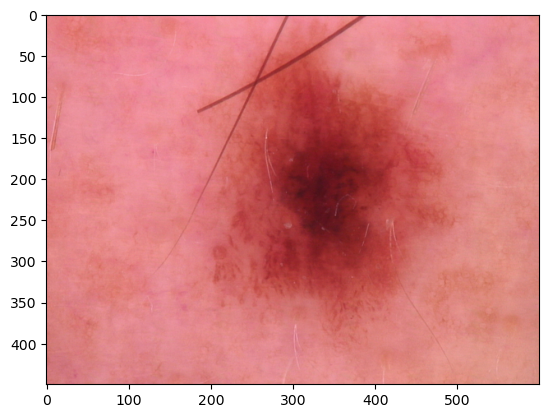

In [11]:
ex_dir = "dermatology/HAM10000_images_part_1"

ex_name = os.listdir(ex_dir)[0]

ex_path = os.path.join(ex_dir, ex_name)

ex1 = cv2.imread(ex_path)

plt.imshow(cv2.cvtColor(ex1, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
ex1.shape

(450, 600, 3)

In [13]:
df

,lesion_id,dx,dx_type,age,sex,localization,dataset
image_id,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,vidir_modern
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,vidir_modern
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,vidir_modern
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,vidir_modern
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...
ISIC_0033084,HAM_0002867,akiec,histo,40.0,male,abdomen,vidir_modern
ISIC_0033550,HAM_0002867,akiec,histo,40.0,male,abdomen,vidir_modern
ISIC_0033536,HAM_0002867,akiec,histo,40.0,male,abdomen,vidir_modern


<Axes: title={'center': 'Sex of patients'}, xlabel='Sex', ylabel='Count'>

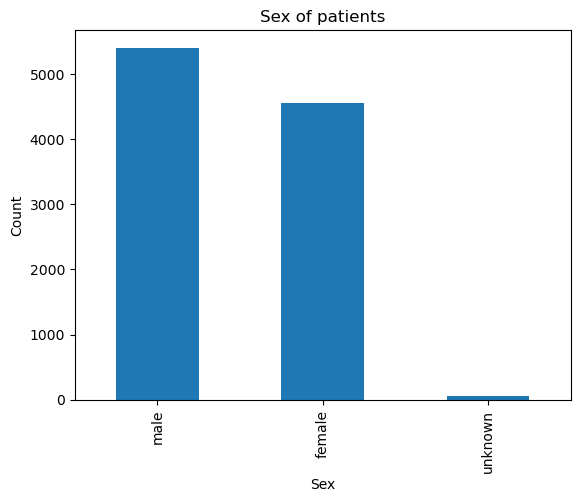

In [14]:
df["sex"].value_counts().plot(kind="bar", title="Sex of patients", xlabel="Sex", ylabel="Count")

Fueron mas comunes los pacientes masculinos.

<Axes: >

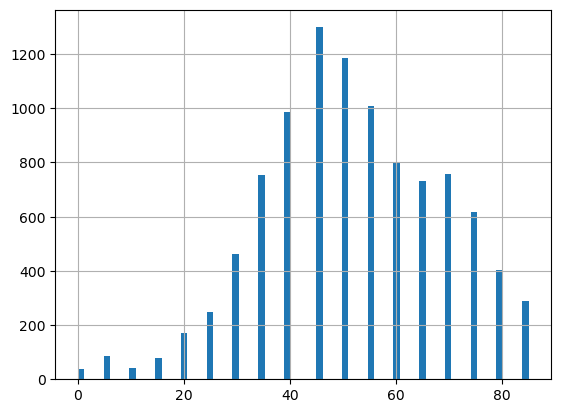

In [15]:
df["age"].hist(bins=70, xlabelsize=10, ylabelsize=10)


La mayoria de pacientes tienen entre 40 y 60 años, siendo el umbral de edad mas frecuente entre 40 y 45 años.

<Axes: title={'center': 'Location of lesions'}, xlabel='Location', ylabel='Count'>

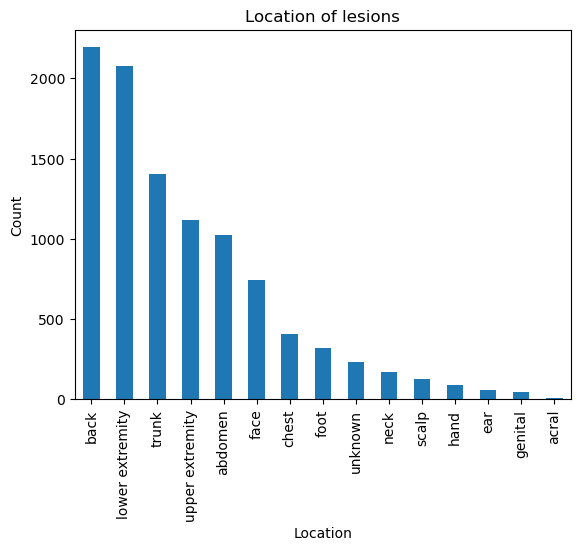

In [16]:
df["localization"].value_counts().plot(kind="bar", title="Location of lesions", xlabel="Location", ylabel="Count")


La mayoria de las lesiones se ubicaron en la espalda.

<Axes: title={'center': 'Type of diagnosis'}, xlabel='Type', ylabel='Count'>

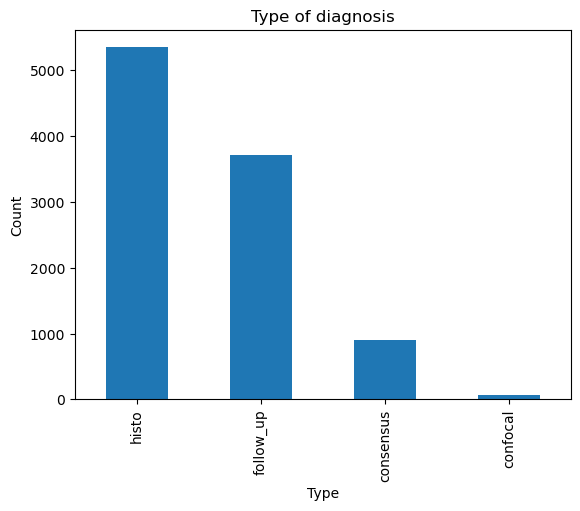

In [17]:
df["dx_type"].value_counts().plot(kind="bar", title="Type of diagnosis", xlabel="Type", ylabel="Count")

El tipo de tratamiento mas frecuente para los pacientes fue Histopatologico.

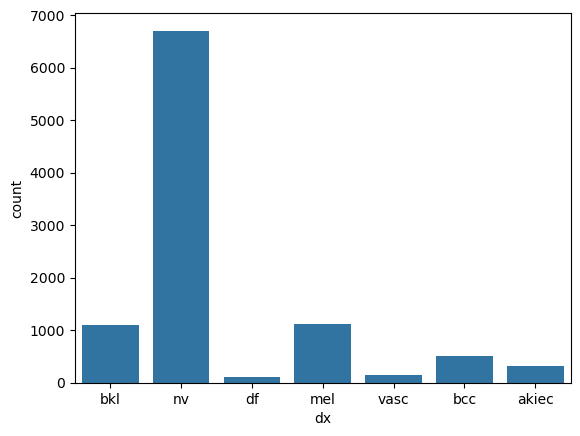

In [18]:
sns.countplot(x=df["dx"])
plt.show()

Las etiquetas de clase del Dataset estan desbalanceadas puesto que hay una notable diferencia entre la cantidad de registros pertenecientes a "nv" y las demas clases.

## Data Augmentation

In [19]:
data_gen = ImageDataGenerator(
    preprocessing_function=base_preprocess,#
    rotation_range=90, #90             ##30      
    width_shift_range=0.1, #0.1 #0.2
    height_shift_range=0.1, #0.1 #0.2
    shear_range=0.1, #0.1 #0.2
    zoom_range=0.3, #0.3                   ##0.2
    horizontal_flip=True, ##
    vertical_flip=True, ##                 ##
    validation_split=0.1)


In [20]:
batch_size = 32 # 32                              64
target_size = (192, 256) # 192, 256                224, 224

In [21]:
train_data = data_gen.flow_from_directory(path, 
                                          target_size=target_size,
                                          batch_size=batch_size,
                                          subset="training")

validation_data = data_gen.flow_from_directory(path, 
                                          target_size=target_size,
                                          batch_size=batch_size,
                                          subset="validation"
                                          )

Found 9017 images belonging to 7 classes.
Found 998 images belonging to 7 classes.


In [22]:
test_data = data_gen.flow_from_directory(path_test, 
                                          target_size=target_size, 
                                          batch_size=batch_size,
                                          shuffle=False
                                          )

Found 1511 images belonging to 7 classes.


In [23]:
train_data.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7059633..0.8296155].


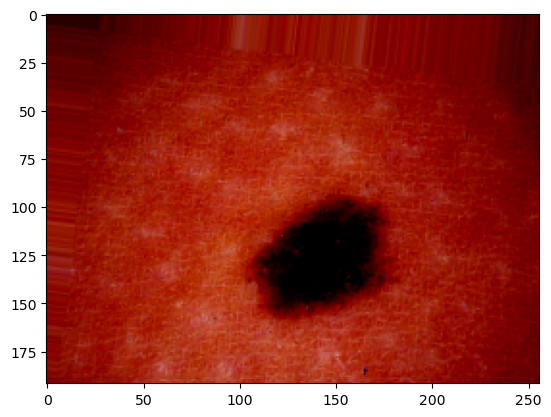

In [24]:
plt.imshow(train_data[0][0][0])


## Transfer Learning mediante el modelo pre-entrenado Xception

### Cargando el modelo pre-entrenado

In [25]:
xceptionModel = Xception(weights="imagenet", input_shape=(192, 256, 3), include_top=False)

In [26]:
for layer in xceptionModel.layers:
    print(layer.name)
    layer.trainable = False # 

input_layer
block1_conv1
block1_conv1_bn
block1_conv1_act
block1_conv2
block1_conv2_bn
block1_conv2_act
block2_sepconv1
block2_sepconv1_bn
block2_sepconv2_act
block2_sepconv2
block2_sepconv2_bn
conv2d
block2_pool
batch_normalization
add
block3_sepconv1_act
block3_sepconv1
block3_sepconv1_bn
block3_sepconv2_act
block3_sepconv2
block3_sepconv2_bn
conv2d_1
block3_pool
batch_normalization_1
add_1
block4_sepconv1_act
block4_sepconv1
block4_sepconv1_bn
block4_sepconv2_act
block4_sepconv2
block4_sepconv2_bn
conv2d_2
block4_pool
batch_normalization_2
add_2
block5_sepconv1_act
block5_sepconv1
block5_sepconv1_bn
block5_sepconv2_act
block5_sepconv2
block5_sepconv2_bn
block5_sepconv3_act
block5_sepconv3
block5_sepconv3_bn
add_3
block6_sepconv1_act
block6_sepconv1
block6_sepconv1_bn
block6_sepconv2_act
block6_sepconv2
block6_sepconv2_bn
block6_sepconv3_act
block6_sepconv3
block6_sepconv3_bn
add_4
block7_sepconv1_act
block7_sepconv1
block7_sepconv1_bn
block7_sepconv2_act
block7_sepconv2
block7_sepco

In [27]:
final_layer = xceptionModel.get_layer("block14_sepconv2_act")
final_layer.output.shape

(None, 6, 8, 2048)

In [28]:
final_output = final_layer.output

### Definiendo el modelo

#### Dropout

In [29]:
predictions = layers.GlobalMaxPooling2D()(final_output) ##
#predictions = Flatten()(final_output) ##
predictions = layers.Dense(512, activation="relu")(predictions) #128, kernel_regularizer="l2" | #512
predictions = layers.Dropout(0.5)(predictions) #0.7
#predictions = BatchNormalization()(predictions) ##
predictions = layers.Dense(7, activation="softmax")(predictions)

model = Model(xceptionModel.input, predictions)
optimizer = Adam(learning_rate=0.0001) #0.001

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [30]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 95, 127,   │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 95, 127,   │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 95, 127,   │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 93, 125,   │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 93, 125,   │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 93, 125,   │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 93, 125,   │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 93, 125,   │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 93, 125,   │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 93, 125,   │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 93, 125,   │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 47, 63,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 47, 63,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 47, 63,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 47, 63,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 47, 63,    │          0 │ add[0][0]       

 Total params: 21,914,159 (83.60 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [31]:
xceptionModel.layers[116].name #126

'block13_sepconv1_act'

#### Fine-Tuning

In [32]:
for layer in xceptionModel.layers[116:]:
    layer.trainable = True

### Re-entrenando el modelo

#### Definiendo los Callbacks

In [33]:
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.000001, cooldown=2)

#
early_stop = EarlyStopping(monitor="val_accuracy",patience=6,mode="auto", restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model_xception.keras", monitor="val_accuracy", verbose=1, save_best_only=True, mode="auto", save_weights_only=False)

In [34]:
callbacks_list = [learning_rate_reduction, early_stop, checkpoint]

In [35]:
epochs = 30

#### Extraccion de Caracteristicas

In [ ]:
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=validation_data,
                    verbose=1,
                    validation_steps=validation_data.samples//batch_size,##
                    callbacks=callbacks_list)

f:\Personal\anaconda3\envs\ml\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6533 - loss: 1.1157
Epoch 1: val_accuracy improved from -inf to 0.74698, saving model to best_model_xceptionn.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 1178s 4s/step - accuracy: 0.6535 - loss: 1.1150 - val_accuracy: 0.7470 - val_loss: 0.7301 - learning_rate: 1.0000e-04
Epoch 2/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7399 - loss: 0.7349
Epoch 2: val_accuracy improved from 0.74698 to 0.76815, saving model to best_model_xceptionn.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 1190s 4s/step - accuracy: 0.7399 - loss: 0.7347 - val_accuracy: 0.7681 - val_loss: 0.6331 - learning_rate: 1.0000e-04
Epoch 3/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7786 - loss: 0.6353
Epoch 3: val_accuracy did not improve from 0.76815
282/282 ━━━━━━━━━━━━━━━━━━━━ 1072s 4s/step - accuracy: 0.7786 - loss: 0.6353 - val_accuracy: 0.7571 - val_loss: 0.6299 - learning_rate: 1.0000e-04
Epoch 4/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accur

## Evaluacion del modelo

In [88]:
import re

training_log = """
Epoch 1/30
251/251  1112s 4s/step - accuracy: 0.6291 - loss: 1.1570 - val_accuracy: 0.7314 - val_loss: 0.7512 - learning_rate: 1.0000e-04
Epoch 2/30
251/251  1066s 4s/step - accuracy: 0.7318 - loss: 0.7557 - val_accuracy: 0.7581 - val_loss: 0.6565 - learning_rate: 1.0000e-04
Epoch 3/30
251/251  1054s 4s/step - accuracy: 0.7651 - loss: 0.6625 - val_accuracy: 0.7737 - val_loss: 0.6223 - learning_rate: 1.0000e-04
Epoch 4/30
251/251  1061s 4s/step - accuracy: 0.7874 - loss: 0.5994 - val_accuracy: 0.7742 - val_loss: 0.6622 - learning_rate: 1.0000e-04
Epoch 5/30
251/251  1177s 5s/step - accuracy: 0.8007 - loss: 0.5736 - val_accuracy: 0.7994 - val_loss: 0.5648 - learning_rate: 1.0000e-04
Epoch 6/30
251/251  1046s 4s/step - accuracy: 0.8194 - loss: 0.5193 - val_accuracy: 0.7969 - val_loss: 0.5680 - learning_rate: 1.0000e-04
Epoch 7/30
251/251  1060s 4s/step - accuracy: 0.8384 - loss: 0.4667 - val_accuracy: 0.8175 - val_loss: 0.5180 - learning_rate: 1.0000e-04
Epoch 8/30
251/251  1037s 4s/step - accuracy: 0.8308 - loss: 0.4735 - val_accuracy: 0.8105 - val_loss: 0.5055 - learning_rate: 1.0000e-04
Epoch 9/30
251/251  1052s 4s/step - accuracy: 0.8431 - loss: 0.4416 - val_accuracy: 0.8024 - val_loss: 0.5279 - learning_rate: 1.0000e-04
Epoch 10/30
251/251  1034s 4s/step - accuracy: 0.8449 - loss: 0.4281 - val_accuracy: 0.8191 - val_loss: 0.5138 - learning_rate: 1.0000e-04
Epoch 11/30
251/251  1026s 4s/step - accuracy: 0.8587 - loss: 0.4015 - val_accuracy: 0.8054 - val_loss: 0.5294 - learning_rate: 1.0000e-04
Epoch 12/30
251/251  1044s 4s/step - accuracy: 0.8555 - loss: 0.3998 - val_accuracy: 0.8216 - val_loss: 0.5077 - learning_rate: 1.0000e-04
Epoch 13/30
251/251  1030s 4s/step - accuracy: 0.8625 - loss: 0.3667 - val_accuracy: 0.8059 - val_loss: 0.5355 - learning_rate: 1.0000e-04
Epoch 14/30
251/251  1025s 4s/step - accuracy: 0.8739 - loss: 0.3588 - val_accuracy: 0.8130 - val_loss: 0.5553 - learning_rate: 1.0000e-04
Epoch 15/30
251/251  1042s 4s/step - accuracy: 0.8773 - loss: 0.3453 - val_accuracy: 0.8246 - val_loss: 0.5061 - learning_rate: 1.0000e-04
Epoch 16/30
251/251  1038s 4s/step - accuracy: 0.8778 - loss: 0.3238 - val_accuracy: 0.8322 - val_loss: 0.5105 - learning_rate: 1.0000e-04
Epoch 17/30
251/251  1005s 4s/step - accuracy: 0.8884 - loss: 0.3070 - val_accuracy: 0.8039 - val_loss: 0.5108 - learning_rate: 1.0000e-04
Epoch 18/30
251/251  991s 4s/step - accuracy: 0.8867 - loss: 0.3100 - val_accuracy: 0.8301 - val_loss: 0.5189 - learning_rate: 1.0000e-04
Epoch 19/30
251/251  1005s 4s/step - accuracy: 0.8910 - loss: 0.3005 - val_accuracy: 0.8327 - val_loss: 0.5250 - learning_rate: 1.0000e-04
Epoch 20/30
251/251  992s 4s/step - accuracy: 0.9012 - loss: 0.2738 - val_accuracy: 0.8261 - val_loss: 0.5366 - learning_rate: 1.0000e-04
Epoch 21/30
251/251  998s 4s/step - accuracy: 0.8954 - loss: 0.2820 - val_accuracy: 0.8256 - val_loss: 0.5286 - learning_rate: 1.0000e-04
Epoch 22/30
251/251  993s 4s/step - accuracy: 0.9024 - loss: 0.2665 - val_accuracy: 0.8266 - val_loss: 0.5627 - learning_rate: 1.0000e-04
Epoch 23/30
251/251  1001s 4s/step - accuracy: 0.9082 - loss: 0.2531 - val_accuracy: 0.8301 - val_loss: 0.5402 - learning_rate: 5.0000e-05
Epoch 24/30
251/251  995s 4s/step - accuracy: 0.9093 - loss: 0.2411 - val_accuracy: 0.8402 - val_loss: 0.5463 - learning_rate: 5.0000e-05
Epoch 25/30
251/251  994s 4s/step - accuracy: 0.9195 - loss: 0.2165 - val_accuracy: 0.8347 - val_loss: 0.5588 - learning_rate: 5.0000e-05
Epoch 26/30
251/251  996s 4s/step - accuracy: 0.9243 - loss: 0.2065 - val_accuracy: 0.8377 - val_loss: 0.5271 - learning_rate: 5.0000e-05
Epoch 27/30
251/251  1012s 4s/step - accuracy: 0.9259 - loss: 0.2050 - val_accuracy: 0.8362 - val_loss: 0.5312 - learning_rate: 5.0000e-05
Epoch 28/30
251/251  1019s 4s/step - accuracy: 0.9297 - loss: 0.2016 - val_accuracy: 0.8392 - val_loss: 0.5815 - learning_rate: 2.5000e-05
Epoch 29/30
251/251  994s 4s/step - accuracy: 0.9325 - loss: 0.1821 - val_accuracy: 0.8488 - val_loss: 0.4970 - learning_rate: 2.5000e-05
Epoch 30/30
251/251  990s 4s/step - accuracy: 0.9372 - loss: 0.1712 - val_accuracy: 0.8443 - val_loss: 0.5471 - learning_rate: 2.5000e-05
"""

epoch_pattern = re.compile(r'Epoch (\d+)/\d+')
metric_pattern = re.compile(r'accuracy: ([\d\.]+) - loss: ([\d\.]+)')
val_metric_pattern = re.compile(r'val_accuracy: ([\d\.]+) - val_loss: ([\d\.]+)')
lr_pattern = re.compile(r'learning_rate: ([\d\.e\-]+)')

history_dict = {
    "accuracy": [],
    "loss": [],
    "val_accuracy": [],
    "val_loss": [],
    "learning_rate": []
}

for line in training_log.split('\n'):
    epoch_match = epoch_pattern.search(line)
    metric_match = metric_pattern.search(line)
    val_metric_match = val_metric_pattern.search(line)
    lr_match = lr_pattern.search(line)
    
    if metric_match:
        accuracy, loss = metric_match.groups()
        history_dict["accuracy"].append(float(accuracy))
        history_dict["loss"].append(float(loss))
    
    if val_metric_match:
        val_accuracy, val_loss = val_metric_match.groups()
        history_dict["val_accuracy"].append(float(val_accuracy))
        history_dict["val_loss"].append(float(val_loss))
    
    if lr_match:
        learning_rate = lr_match.group(1)
        history_dict["learning_rate"].append(float(learning_rate))

In [89]:
df_metrics = pd.DataFrame(history_dict)
df_metrics

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.6291,1.1570,0.7314,0.7512,0.000100
1,0.7318,0.7557,0.7581,0.6565,0.000100
2,0.7651,0.6625,0.7737,0.6223,0.000100
3,0.7874,0.5994,0.7742,0.6622,0.000100
4,0.8007,0.5736,0.7994,0.5648,0.000100
5,0.8194,0.5193,0.7969,0.5680,0.000100
6,0.8384,0.4667,0.8175,0.5180,0.000100
7,0.8308,0.4735,0.8105,0.5055,0.000100
8,0.8431,0.4416,0.8024,0.5279,0.000100
9,0.8449,0.4281,0.8191,0.5138,0.000100


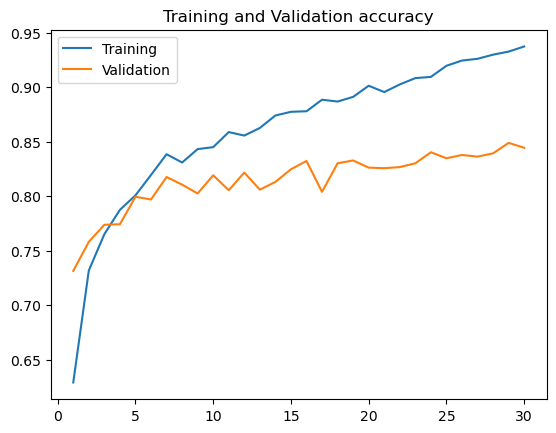

In [90]:
train_accuracy = df_metrics["accuracy"]
validation_accuracy = df_metrics["val_accuracy"]

epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, label = "Training")
plt.plot(epochs, validation_accuracy, label = "Validation")
plt.legend(loc="upper left")
plt.title("Training and Validation accuracy")
plt.show()

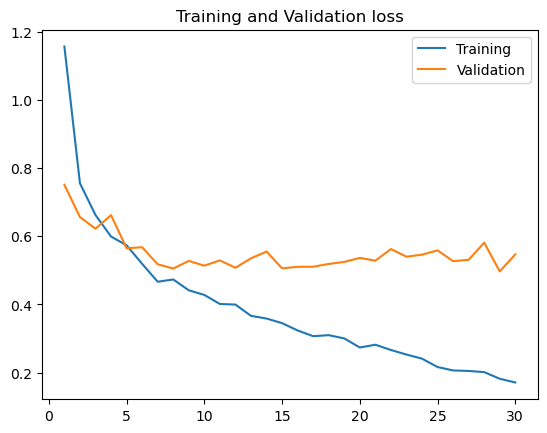

In [91]:
train_loss = df_metrics["loss"]
validation_loss = df_metrics["val_loss"]

plt.plot(epochs, train_loss, label = "Training")
plt.plot(epochs, validation_loss, label = "Validation")
plt.legend(loc="upper right")
plt.title("Training and Validation loss")
plt.show()

### Test

In [28]:
loaded_model = load_model("best_model_xceptionn.keras") #

In [35]:
y_predictions = loaded_model.predict(test_data, verbose=1)
y_predictions = y_predictions.argmax(axis=1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step


In [ ]:
y_predictions

array([0, 0, 0, ..., 5, 4, 4])

In [37]:
test_labels = test_data.classes
test_labels

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [38]:
confusion_matrix(y_predictions, test_labels)

array([[ 29,   7,   8,   2,   3,   5,   0],
       [  7,  52,   7,   2,   2,   6,   1],
       [  1,  12, 139,   3,  10,  16,   0],
       [  1,   0,   0,  27,   1,   1,   3],
       [  4,  12,  27,   1, 102,  43,   2],
       [  1,  10,  36,   9,  53, 837,  10],
       [  0,   0,   0,   0,   0,   0,  19]])

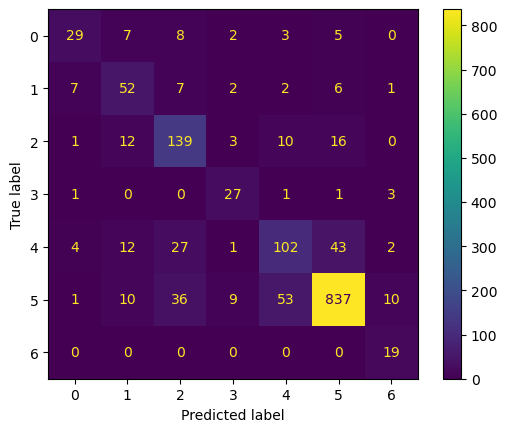

In [39]:
confusionMatrix = ConfusionMatrixDisplay(confusion_matrix(y_predictions, test_labels))
confusionMatrix.plot()
plt.show()

In [40]:
print(classification_report(test_labels, y_predictions))


              precision    recall  f1-score   support

           0       0.54      0.67      0.60        43
           1       0.68      0.56      0.61        93
           2       0.77      0.64      0.70       217
           3       0.82      0.61      0.70        44
           4       0.53      0.60      0.56       171
           5       0.88      0.92      0.90       908
           6       1.00      0.54      0.70        35

    accuracy                           0.80      1511
   macro avg       0.74      0.65      0.68      1511
weighted avg       0.80      0.80      0.80      1511



In [41]:
class_accuracy = []

for i in range(7):
    class_acc = round(np.mean(test_labels[test_labels == i] == y_predictions[test_labels == i]), 2)
    label = classes[i]
    class_accuracy.append(class_acc)

df_accuracy = pd.DataFrame(list(zip(classes, class_accuracy)))
df_accuracy.columns = ["Class", "Accuracy"]
df_accuracy

,Class,Accuracy
0,akiec,0.67
1,bcc,0.56
2,bkl,0.64
3,df,0.61
4,mel,0.60
5,nv,0.92
6,vasc,0.54


# FIN